# Notebook 01: Dataset Preparation and Baseline Response Generation

## 📋 **Overview**
This notebook transforms the **synthetic conversations from Notebook 00** into structured training examples for DSPy judge optimization. It creates truncated conversation scenarios and generates baseline agent responses that will be used to train and evaluate our DSPy judge in subsequent notebooks.

## 🔄 **Complete Workflow with Example**

Continuing from Notebook 00's output, let's walk through the data transformation process using the same flight booking conversation:

### **Starting Point (from Notebook 00)**
We begin with the complete synthetic conversation that was generated from this original input:

**Original Input:**
```
Text: "Customer: i just booked my flight and i have received a email but im not sure if it went through or not, i cant go to the web site and see my itinerary"
Number of words: 34
```

**Generated Full Conversation (Notebook 00 output):**
```
Company: Southwest Airlines
Conversation:
Customer: i just booked my flight and i have received a email but im not sure if it went through or not, i cant go to the web site and see my itinerary
Agent: Hello! I understand your concern about your flight booking. Let me help you verify your reservation.
Customer: The email just says payment received with an order number, no confirmation code
Agent: I can look up your booking with the order number. Can you provide that along with your full name?
Customer: Order #12345, John Smith
Agent: Found your booking! Your confirmation code is ABC123. Your flight is confirmed for tomorrow at 2:30 PM from Boston to Chicago.
```

### **Phase 1: Data Loading & Preprocessing**
1. **Load synthetic conversations** from `datasets/airline_support_conversations` (generated in Notebook 00)
2. **Preprocess data** to standardize format and extract key fields
3. **Sample conversations** for baseline generation (400 examples)

### **Phase 2: Conversation Truncation**
4. **Truncate conversations** using `ConversationTruncator` to create incomplete scenarios
5. **Ensure customer speaks last** to set up response generation context
6. **Preserve conversation context** while creating natural stopping points

**Example Transformation:**
```
Original: 8 turns (4 customer + 4 agent messages)
Truncated: 6 turns (ending with customer message)

Truncated Conversation:
Customer: i just booked my flight and i have received a email but im not sure if it went through or not, i cant go to the web site and see my itinerary
Agent: Hello! I understand your concern about your flight booking. Let me help you verify your reservation.
Customer: The email just says payment received with an order number, no confirmation code
Agent: I can look up your booking with the order number. Can you provide that along with your full name?
Customer: Order #12345, John Smith
[TRUNCATED - Agent response needed]
```

### **Phase 3: Baseline Response Generation**
7. **Generate baseline agent responses** using DSPy ChainOfThought with GPT-3.5-turbo
8. **Create company_and_transcript field** combining company context with conversation
9. **Process in parallel** for efficient baseline generation

**Input to Baseline Model:**
```
Company: Southwest Airlines
Transcript so far:
Customer: i just booked my flight and i have received a email but im not sure if it went through or not, i cant go to the web site and see my itinerary
Agent: Hello! I understand your concern about your flight booking. Let me help you verify your reservation.
Customer: The email just says payment received with an order number, no confirmation code
Agent: I can look up your booking with the order number. Can you provide that along with your full name?
Customer: Order #12345, John Smith

What should the agent respond next?
```

**Generated Baseline Response:**
```
"Found your booking! Your confirmation code is ABC123. Your flight is confirmed for tomorrow at 2:30 PM from Boston to Chicago."
```

### **Phase 4: Dataset Organization & Splitting**
10. **Calculate response metrics** (word count, readability score)
11. **Create train/test splits** (60% train, 40% test)
12. **Save structured datasets** for use in judge optimization (Notebooks 02-03)

**Final Dataset Structure:**
```python
{
  'conversation': "Customer: i just booked...",  # Original full conversation
  'truncated_conversation': "Customer: i just...",  # Incomplete scenario
  'company_and_transcript': "Company: Southwest Airlines\nTranscript...",  # Input format
  'llm_response': "Found your booking! Your confirmation...",  # Baseline response
  'dspy_response': {...},  # DSPy module output with metadata
  'count_words_response': 15,  # Response length metric
  'output_readability': 85.2  # Flesch reading ease score
}
```

## 🎯 **Key Components**

### **ConversationTruncator**
- Creates incomplete conversation scenarios by randomly truncating at customer messages
- Configurable parameters: `min_turns=1`, `ensure_customer_last=True`
- Preserves conversation flow while creating realistic stopping points

### **DSPy ChainOfThought Baseline**
- Uses `SupportTranscriptNextResponse` signature for structured generation
- Temperature=1.0 for diverse response generation
- Processes company context + conversation history → agent response

### **Data Flow Transformation**
1. **Synthetic Conversations** (Notebook 00) → **Truncated Scenarios** (Phase 2)
2. **Truncated Scenarios** → **Baseline Responses** (Phase 3) 
3. **Training Examples** → **Judge Optimization** (Notebooks 02-03)

## 📁 **File Organization**
- **Input**: `datasets/airline_support_conversations` (from Notebook 00)
- **Output**: `datasets/preprocessed_dev_judge_dataset_split` (train/test splits)
- **Intermediate**: `datasets/preprocessed_full_dataset_truncated` (truncated conversations)

## 🔗 **Pipeline Integration**
This notebook bridges the **data generation phase** (Notebook 00) and the **judge optimization phase** (Notebooks 02-03):
- Takes synthetic conversations as input
- Produces structured training examples as output
- Provides baseline agent responses for comparison
- Creates evaluation datasets for judge performance measurement

# Load data, preprocess and run baseline prompt

In [1]:
%load_ext autoreload
%autoreload 2

In [90]:
%pip install textstat

Note: you may need to restart the kernel to use updated packages.


In [91]:
from dspy_judge.llm_caller.utils import load_secrets
from dspy_judge.data_loader.dataset_loader import CustomerSupportDatasetLoader
from dspy_judge.llm_caller import AnthropicStructuredOutputCaller, OpenAITextOutputCaller, GeminiStructuredOutputCaller
from dspy_judge.processor.parallel_processor import ParallelProcessor
from dspy_judge.prompts.pydantic_models import JudgeResponse
from dspy_judge.processor.utils import extract_llm_response_fields, concat_company_and_conversation, concat_latest_response, concat_latest_response_dspy
from dspy_judge.prompts.dspy_signatures import SupportTranscriptNextResponse
from dspy_judge.processor.conversation_truncator import ConversationTruncator
from dspy_judge.prompts.base_prompts import baseline_customer_response_support_system_prompt
import dspy
import seaborn as sns
import textstat
import matplotlib.pyplot as plt

In [92]:
secrets = load_secrets()

## Load conversations

In [93]:
data_loader = CustomerSupportDatasetLoader()

In [94]:
# load datasets/airline_support_conversations
dataset = data_loader.load_dataset(split="train")

2025-11-06 20:08:43 - dspy_judge.data_loader.dataset_loader - INFO - Loading local dataset from c:\Projects\Tutorial\llm_judge_with_dspy-main\datasets\airline_support_conversations...


2025-11-06 20:08:44 - dspy_judge.data_loader.dataset_loader - INFO - Dataset loaded successfully. Size: 50


In [129]:
dataset[4]

{'conversation_id': 'Session:2057187615:14644',
 'Text': "Trying to sort out a friend's return flight from Heathrow but no luck with the usual telephone number. I thought somebody posted another number some time ago but I've searched and can't find anything.",
 'number_of_words': 34,
 'llm_response': "Company: Delta Air Lines\nConversation:\nCustomer: Trying to sort out a friend's return flight from Heathrow but no luck with the usual telephone number. I thought somebody posted another number some time ago but I've searched and can't find anything.\nSupport: Hello! I understand you're having trouble reaching us by phone. For security reasons, I can only discuss booking details with the ticketed passenger. Can your friend contact us directly?\nCustomer: That's the problem, she's trying but the line just keeps cutting off! She needs to change her flight home from LHR. Is there any email or chat option specifically for changes from the UK?\nSupport: Our primary contact method for changes 

In [128]:
print("Customer: Trying to sort out a friend's return flight from Heathrow but no luck with the usual telephone number. I thought somebody posted another number some time ago but I've searched and can't find anything.\nSupport:  The main number is 800-433-7300.  What information do you need regarding your friend's flight?  A confirmation number would be helpful.\nCustomer:  I don't have a confirmation number.  It's for a friend; I only have her name and the approximate travel dates – sometime in October.  Is there another way to track this down?\nSupport:  Unfortunately, without a confirmation number or more precise dates, tracking her flight is impossible.  Have her check her email inbox for a confirmation.  If she can't find it, she should contact us directly.")

Customer: Trying to sort out a friend's return flight from Heathrow but no luck with the usual telephone number. I thought somebody posted another number some time ago but I've searched and can't find anything.
Support:  The main number is 800-433-7300.  What information do you need regarding your friend's flight?  A confirmation number would be helpful.
Customer:  I don't have a confirmation number.  It's for a friend; I only have her name and the approximate travel dates – sometime in October.  Is there another way to track this down?
Support:  Unfortunately, without a confirmation number or more precise dates, tracking her flight is impossible.  Have her check her email inbox for a confirmation.  If she can't find it, she should contact us directly.


📊 Before vs After Transformation:
BEFORE preprocessing:

{
  'conversation_id': 'Session:2057187615:14644',
  'Text': "Trying to sort out a friend's return flight...",
  'number_of_words': 34,
  'llm_response': "Company: Delta Air Lines\nConversation:\n...",
  'llm_metadata': 'response:\nGenerateContentResponse(...)',  # Large metadata object
  'input_tokens': 0,
  'output_tokens': 0,
  'company': 'Delta Air Lines',
  'conversation': "Customer: Trying to sort out...\nSupport: Hello!..."
}

AFTER preprocessing:
{
  'conversation_id': 'Session:2057187616:14759',
  'Text': "Looking to do 5 night trip to New York...",
  'number_of_words': 31,
  'llm_response': "Company: American Airlines\nConversation:\n...",
  'input_tokens': 0,
  'output_tokens': 0,
  'company': 'American Airlines', 
  'conversation': "Customer: Looking to do 5 night trip...",
  'conversation_word_count': 190,        # ✅ NEW: Word count analysis
  'conversation_language': 'en'          # ✅ NEW: Language detection
  # REMOVED: llm_metadata (cleanup)
}

🎯 Purpose in the Pipeline:
This preprocessing step prepares the synthetic conversations for the next phases:

Clean data for better processing quality
Add metrics (word count, language) for dataset analysis
Remove bloat (metadata) to reduce memory usage
Standardize format for consistent downstream processing

In [97]:
processed_dataset = data_loader.preprocess_dataset(dataset)

2025-11-06 20:08:53 - dspy_judge.data_loader.dataset_loader - INFO - Removed columns: ['llm_metadata']


In [100]:
data_loader.save_dataset_locally(processed_dataset,"datasets/preprocessed_full_dataset")

Saving the dataset (1/1 shards): 100%|██████████| 50/50 [00:00<00:00, 5001.08 examples/s]
2025-11-06 20:09:41 - dspy_judge.data_loader.dataset_loader - INFO - Dataset saved to datasets/preprocessed_full_dataset


In [101]:
pre_processed_loaded  = data_loader.load_local_dataset("datasets/preprocessed_full_dataset")

2025-11-06 20:09:50 - dspy_judge.data_loader.dataset_loader - INFO - Local dataset loaded from datasets/preprocessed_full_dataset. Size: 50


In [127]:
# Display the first 2 rows of the truncated samples as a pandas DataFrame
display(pre_processed_loaded.select(range(2)).to_pandas())

,conversation_id,Text,number_of_words,llm_response,input_tokens,output_tokens,company,conversation,conversation_word_count,conversation_language
0,Session:2057187616:14759,Looking to do 5 night trip to New York next Ea...,31,Company: American Airlines\nConversation:\nCus...,0,0,American Airlines,Customer: Looking to do 5 night trip to New Yo...,190,en
1,Session:2057187615:14832,Does anyone know if there is a particular time...,29,Company: Southwest Airlines\nConversation:\nCu...,0,0,Southwest Airlines,Customer: Does anyone know if there is a parti...,115,en


## Truncate conversations

In [103]:
truncator = ConversationTruncator(seed=101)
truncated_dataset = truncator.process_dataset(
    pre_processed_loaded,
    min_turns=1,
    ensure_customer_last=True
)
truncated_dataset = truncated_dataset.map(concat_company_and_conversation)

Map: 100%|██████████| 50/50 [00:00<00:00, 1245.04 examples/s]


In [104]:
# Display the first 2 rows of the truncated samples as a pandas DataFrame
display(truncated_dataset.select(range(2)).to_pandas())

,conversation_id,Text,number_of_words,llm_response,input_tokens,output_tokens,company,conversation,conversation_word_count,conversation_language,truncated_conversation,company_and_transcript
0,Session:2057187616:14759,Looking to do 5 night trip to New York next Ea...,31,Company: American Airlines\nConversation:\nCus...,0,0,American Airlines,Customer: Looking to do 5 night trip to New Yo...,190,en,Customer: Looking to do 5 night trip to New Yo...,Company: American Airlines\nTranscript so far:...
1,Session:2057187615:14832,Does anyone know if there is a particular time...,29,Company: Southwest Airlines\nConversation:\nCu...,0,0,Southwest Airlines,Customer: Does anyone know if there is a parti...,115,en,Customer: Does anyone know if there is a parti...,Company: Southwest Airlines\nTranscript so far...


In [105]:
# Let's see the clear difference between original and truncated conversations
print("🔍 COMPARISON: Original vs Truncated Conversations")
print("="*70)

for i in range(2):
    print(f"\n📋 EXAMPLE {i+1}:")
    print(f"Company: {truncated_dataset[i]['company']}")
    
    print(f"\n📜 ORIGINAL CONVERSATION ({len(truncated_dataset[i]['conversation'].split('Customer:')) + len(truncated_dataset[i]['conversation'].split('Support:')) - 2} turns):")
    print(truncated_dataset[i]['conversation'][:200] + "..." if len(truncated_dataset[i]['conversation']) > 200 else truncated_dataset[i]['conversation'])
    
    print(f"\n✂️ TRUNCATED CONVERSATION ({len(truncated_dataset[i]['truncated_conversation'].split('Customer:')) + len(truncated_dataset[i]['truncated_conversation'].split('Agent:')) - 2} turns):")
    print(truncated_dataset[i]['truncated_conversation'])
    
    print(f"\n💡 DIFFERENCE: Truncated version is shorter - removed {len(truncated_dataset[i]['conversation']) - len(truncated_dataset[i]['truncated_conversation'])} characters")
    print("-" * 50)

🔍 COMPARISON: Original vs Truncated Conversations

📋 EXAMPLE 1:
Company: American Airlines

📜 ORIGINAL CONVERSATION (6 turns):
Customer: Looking to do 5 night trip to New York next Easter. Best price at present is with BA (NCL to LHR to JFK) Â£540. Should we wait for Xmas/new year sale?
Support: Hello. We cannot advise on fut...

✂️ TRUNCATED CONVERSATION (5 turns):
Customer: Looking to do 5 night trip to New York next Easter. Best price at present is with BA (NCL to LHR to JFK) Â£540. Should we wait for Xmas/new year sale?
Agent: Hello. We cannot advise on future pricing or sales. Prices fluctuate constantly based on demand. The best current price for American Airlines flights is what is showing on our website.
Customer: I understand you can't predict. But historically, does American Airlines usually have good sales for international flights around Christmas for next spring travel? Just trying to gauge if it's worth waiting.
Agent: We do not provide historical pricing data or projecti

In [106]:
data_loader.save_dataset_locally(truncated_dataset,"datasets/preprocessed_full_dataset_truncated")

Saving the dataset (1/1 shards): 100%|██████████| 50/50 [00:00<00:00, 6248.22 examples/s]
2025-11-06 20:10:27 - dspy_judge.data_loader.dataset_loader - INFO - Dataset saved to datasets/preprocessed_full_dataset_truncated


In [107]:
truncated_loaded_sampled = data_loader.get_sample(truncated_dataset,n_samples=400,seed=10)

In [108]:
truncated_loaded_sampled

Dataset({
    features: ['conversation_id', 'Text', 'number_of_words', 'llm_response', 'input_tokens', 'output_tokens', 'company', 'conversation', 'conversation_word_count', 'conversation_language', 'truncated_conversation', 'company_and_transcript'],
    num_rows: 50
})

In [109]:
# Display the first 2 rows of the truncated samples as a pandas DataFrame
display(truncated_loaded_sampled.select(range(2)).to_pandas())

,conversation_id,Text,number_of_words,llm_response,input_tokens,output_tokens,company,conversation,conversation_word_count,conversation_language,truncated_conversation,company_and_transcript
0,Session:2057187647:22512,Been searching airfares for upcoming summer '1...,39,Company: USAir\nConversation:\nCustomer: Been ...,0,0,USAir,Customer: Been searching airfares for upcoming...,142,en,Customer: Been searching airfares for upcoming...,Company: USAir\nTranscript so far: Customer: B...
1,Session:2057187648:19953,if i need to cancel our flight this week topho...,20,Company: American Airlines\nConversation:\nCus...,0,0,American Airlines,Customer: if i need to cancel our flight this ...,164,en,Customer: if i need to cancel our flight this ...,Company: American Airlines\nTranscript so far:...


In [110]:
# Inspect first row fields
row = truncated_loaded_sampled[0]
print("truncated_conversation:\n")
print(row["truncated_conversation"])
print("\n\ncompany_and_transcript:\n")
print(row["company_and_transcript"])

truncated_conversation:

Customer: Been searching airfares for upcoming summer '13 trip to London & Paris. Travelling w/ daughter, my father and his wife, and possibly aunt. it looks like USAir is the only choice, (running ~1500-1600 pp. w/ taxes).is this price reasonable
Agent: Hi! We cannot advise on the "reasonableness" of current ticket prices or compare them to past market trends. Prices fluctuate constantly based on demand and availability. Please check our website for the most up-to-date fares.
Customer: I understand prices change, but given it's 2013, am I likely to see better prices for summer travel or should I book now? I want to fly with USAir if possible.


company_and_transcript:

Company: USAir
Transcript so far: Customer: Been searching airfares for upcoming summer '13 trip to London & Paris. Travelling w/ daughter, my father and his wife, and possibly aunt. it looks like USAir is the only choice, (running ~1500-1600 pp. w/ taxes).is this price reasonable
Agent: Hi! We 

## Run baseline model

### Option 1: dspy generation


In [111]:
# Create DSPy configuration for multiprocessing
dspy_config = {
  "model_name": "openai/gpt-3.5-turbo",
  "api_key": secrets["OPENAI_API_KEY"],
  "signature_class": SupportTranscriptNextResponse,
  "temperature": 1
}

support_transcript_generator_module = dspy.ChainOfThought(SupportTranscriptNextResponse)

# Initialize processor with both module and config
dspy_judge_processor = ParallelProcessor()

# Now this should work without pickling errors
dspy_judge_results = dspy_judge_processor.process_dataset_with_dspy(
  truncated_loaded_sampled,
  input_field="company_and_transcript",
  dspy_module=support_transcript_generator_module,
  dspy_config=dspy_config
)

2025-11-06 20:12:28 - dspy_judge.processor.parallel_processor - INFO - Initialized ParallelProcessor with max_workers=4
2025-11-06 20:12:28 - dspy_judge.processor.parallel_processor - INFO - Processing 50 examples with 4 workers using DSPy...
Processing with DSPy: 100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


In [112]:
dspy_baseline_results = dspy_judge_results.map(concat_latest_response_dspy)

Map: 100%|██████████| 50/50 [00:00<00:00, 2083.48 examples/s]


In [113]:
dspy_baseline_output_pd = dspy_baseline_results.to_pandas()

In [114]:
dspy_baseline_output_pd["count_words_response"] = dspy_baseline_output_pd["dspy_response"].apply(
    lambda x: len(x["llm_response"].split())
)
dspy_baseline_output_pd["output_readability"] = dspy_baseline_output_pd["dspy_response"].apply(
    lambda x: textstat.flesch_reading_ease(x["llm_response"])
)

In [115]:
# Display the first two rows of the dspy baseline output dataframe
display(dspy_baseline_output_pd.head(2))

,conversation_id,Text,number_of_words,llm_response,input_tokens,output_tokens,company,conversation,conversation_word_count,conversation_language,truncated_conversation,company_and_transcript,dspy_response,dspy_metadata,output_transcript,count_words_response,output_readability
0,Session:2057187647:22512,Been searching airfares for upcoming summer '1...,39,Company: USAir\nConversation:\nCustomer: Been ...,0,0,USAir,Customer: Been searching airfares for upcoming...,142,en,Customer: Been searching airfares for upcoming...,Company: USAir\nTranscript so far: Customer: B...,{'llm_response': 'Booking flight tickets for s...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: USAir\nTranscript so far: Customer: B...,71,67.280722
1,Session:2057187648:19953,if i need to cancel our flight this week topho...,20,Company: American Airlines\nConversation:\nCus...,0,0,American Airlines,Customer: if i need to cancel our flight this ...,164,en,Customer: if i need to cancel our flight this ...,Company: American Airlines\nTranscript so far:...,{'llm_response': 'To cancel and reschedule you...,{'raw': '{'openai/gpt-3.5-turbo': {'completion...,Company: American Airlines\nTranscript so far:...,43,68.337829


In [116]:
# Print requested fields for the first row from the dspy baseline dataframe
row = dspy_baseline_output_pd.iloc[0]

print("llm_response:\n")
print(row["llm_response"])

print("\nconversation:\n")
print(row["conversation"])

print("\ncompany_and_transcript:\n")
print(row["company_and_transcript"])

print("\ndspy_response (raw):\n")
print(row["dspy_response"])

# If dspy_response is a dict with an 'llm_response' field, print that as well
if isinstance(row["dspy_response"], dict) and "llm_response" in row["dspy_response"]:
    print("\ndspy_response['llm_response']:\n")
    print(row["dspy_response"]["llm_response"])

print("\noutput_transcript:\n")
print(row.get("output_transcript", "<no output_transcript column>"))

llm_response:

Company: USAir
Conversation:
Customer: Been searching airfares for upcoming summer '13 trip to London & Paris. Travelling w/ daughter, my father and his wife, and possibly aunt. it looks like USAir is the only choice, (running ~1500-1600 pp. w/ taxes).is this price reasonable
Support: Hi! We cannot advise on the "reasonableness" of current ticket prices or compare them to past market trends. Prices fluctuate constantly based on demand and availability. Please check our website for the most up-to-date fares.
Customer: I understand prices change, but given it's 2013, am I likely to see better prices for summer travel or should I book now? I want to fly with USAir if possible.
Support: We cannot predict future price movements. The price you see now is the current available fare for those dates and routes. We recommend booking when you are ready to secure your preferred itinerary.

conversation:

Customer: Been searching airfares for upcoming summer '13 trip to London & Pari

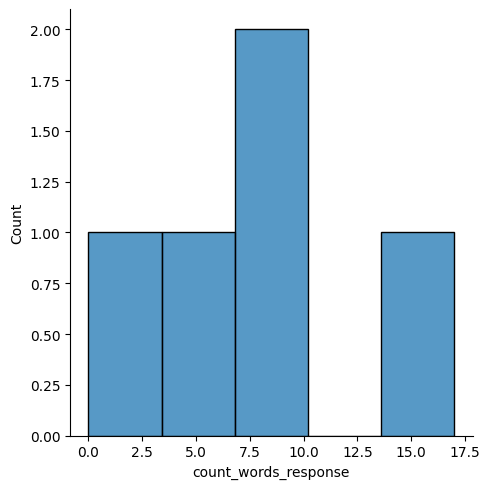

In [22]:
sns.displot(data=dspy_baseline_output_pd,x="count_words_response")

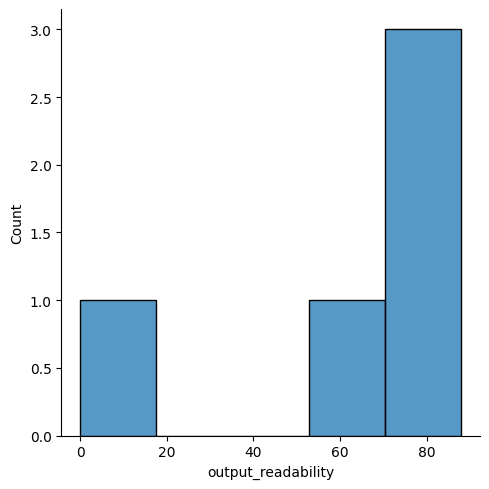

In [23]:
sns.displot(data=dspy_baseline_output_pd,x="output_readability")

### Option 2: Generate using traditional approach

In [88]:
baseline_model_name = "gpt-3.5-turbo"
baseline_model = OpenAITextOutputCaller(api_key=secrets["OPENAI_API_KEY"])
baseline_processor = ParallelProcessor(baseline_model, max_workers=4)
baseline_results = baseline_processor.process_dataset(
        truncated_loaded_sampled,
        system_prompt=baseline_customer_response_support_system_prompt,
        model_name=baseline_model_name,
        input_field="company_and_transcript",
        temperature=1.0
    )

2025-11-06 16:35:33 - dspy_judge.processor.parallel_processor - INFO - Initialized ParallelProcessor with max_workers=4
2025-11-06 16:35:33 - dspy_judge.processor.parallel_processor - INFO - Processing 50 examples with 4 workers...
Processing with LLM: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


In [25]:
baseline_results = baseline_results.map(concat_latest_response)

Map: 100%|██████████| 5/5 [00:00<00:00, 624.95 examples/s]


In [26]:
baseline_results_pd = baseline_results.to_pandas()

In [27]:
baseline_results_pd["count_words_response"] = baseline_results_pd["llm_response"].apply(lambda x: len(x.split()))
baseline_results_pd["output_readability"] = baseline_results_pd["llm_response"].apply(lambda x: textstat.flesch_reading_ease(x))

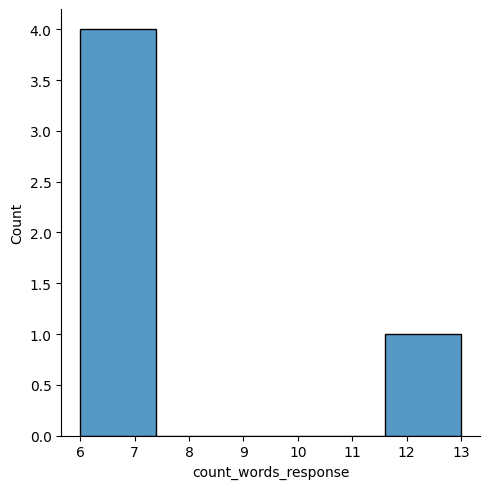

In [28]:
sns.displot(data=baseline_results_pd,x="count_words_response")

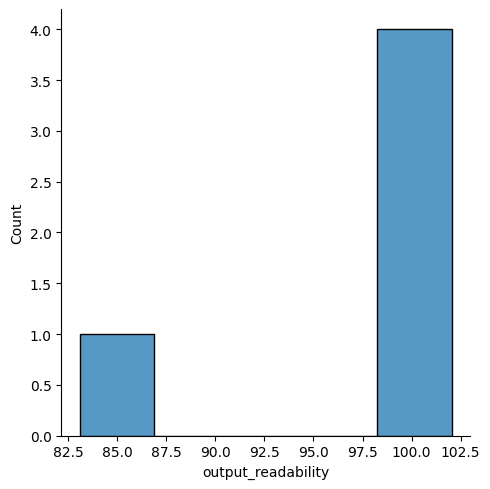

In [29]:
sns.displot(data=baseline_results_pd,x="output_readability")

## Split the output dataset

Train will be the dev dataset, test will be the dataset we'll use for judge validation

In [117]:
split_ds = dspy_baseline_results.train_test_split(test_size=0.4, seed=10)

In [125]:
# Check for empty or whitespace-only strings in 'conversation' for each split in split_ds
for split_name, ds in split_ds.items():
    df = ds.to_pandas()
    if "conversation" not in df.columns:
        print(f"{split_name}: no 'conversation' column found")
        continue

    empty_mask = df["conversation"].isnull() | df["conversation"].astype(str).str.strip().eq("")
    empty_count = int(empty_mask.sum())
    total = len(df)

    print(f"{split_name}: {empty_count} empty/whitespace-only out of {total} rows")

    if empty_count > 0:
        print(df.loc[empty_mask, ["conversation_id", "conversation"]].head(20).to_string(index=False))

train: 4 empty/whitespace-only out of 30 rows
         conversation_id conversation
Session:2057187616:13717             
Session:2057187614:20758             
Session:2057187647:17352             
Session:2057187640:31739             
test: 2 empty/whitespace-only out of 20 rows
         conversation_id conversation
Session:2057187648:15236             
Session:2057187648:13769             


In [124]:
import json

# Print the text value of the first row's dspy_response in split_ds (train split)
row = split_ds["train"][0]
dspy_resp = row.get("dspy_response")
print(dspy_resp)
print("<BR>")
llm_resp = row.get("llm_response")
print(llm_resp)

print("<BR>")

llm_output_trans = row.get("output_transcript")
print(llm_output_trans)


{'llm_response': "I understand your concern. Since you are logged into the correct account and the website isn't working for you, let me assist you in obtaining a confirmation code manually. Please provide me with your order number, and I will work on getting the confirmation code for you.", 'reasoning': 'The customer is unable to access their trip details and is concerned about whether their flight is confirmed or not.'}
<BR>
Company: Southwest Airlines
Conversation:
Customer: i just booked my flight and i have received a email but im not sure if it went through or not, i cant go to the web site and see my itinerary
Support: Hello. If you received an email, your booking is likely confirmed. Please provide the confirmation number from that email for verification.
Customer: The email I got just says 'Payment Received' and has an order number, not a confirmation code for a flight. And I still can't access my trip details on your site.
Support: We require a confirmation code to look up fl

In [119]:
data_loader.save_dataset_locally(split_ds,"datasets/preprocessed_dev_judge_dataset_split")

Saving the dataset (1/1 shards): 100%|██████████| 20/20 [00:00<00:00, 2499.81 examples/s]
2025-11-06 20:24:14 - dspy_judge.data_loader.dataset_loader - INFO - Dataset saved to datasets/preprocessed_dev_judge_dataset_split
